In [1]:
from collections import OrderedDict
import glob
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import open3d as o3d
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from learning3d.models import PointNet, Classifier
from learning3d.data_utils import ClassificationData, ModelNet40Data

# PointNet

In [2]:
pn = PointNet(emb_dims=1024, use_bn=True)

In [3]:
pn

PointNet(
  (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv5): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (relu): ReLU()
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [4]:
model = Classifier(feature_model=pn)

In [5]:
model_path = "/Users/photosartd/repositories/learning3d/pretrained/exp_classifier/models/best_model.t7"
root_dir = "/Users/photosartd/repositories/learning3d/data"

In [6]:
model.load_state_dict(torch.load(model_path, map_location="cpu"))

<All keys matched successfully>

In [7]:
model

Classifier(
  (feature_model): PointNet(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv5): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (relu): ReLU()
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p

In [8]:
testset = ClassificationData(ModelNet40Data(train=True, num_points=1024, download=True))
test_loader = DataLoader(testset, batch_size=32, shuffle=False, drop_last=False)

In [9]:
# Assume 'model' is your pre-trained model
model_layers = list(model.children())

# Number of layers to keep (for example, remove the last 2 layers)
num_layers_to_keep = len(model_layers) - 2

# Alternatively, if using named layers:
new_model = nn.Sequential(OrderedDict(list(model.named_children())[:num_layers_to_keep]))

print(new_model)

Sequential(
  (feature_model): PointNet(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv5): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (relu): ReLU()
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p

In [10]:
batch = next(iter(test_loader))

In [11]:
batch[0].shape

torch.Size([32, 1024, 3])

In [12]:
new_model.eval()

Sequential(
  (feature_model): PointNet(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv5): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (relu): ReLU()
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p

In [13]:
r = model(batch[0])

In [14]:
r.shape

torch.Size([32, 40])

In [15]:
model.linear3 = nn.Identity()

In [16]:
r = model(batch[0])

In [17]:
r.shape

torch.Size([32, 256])

In [18]:
r_sim = torch.nn.functional.cosine_similarity(
    r.unsqueeze(1),
    r.unsqueeze(0),
    dim=2
)

In [19]:
r_sim.shape

torch.Size([32, 32])

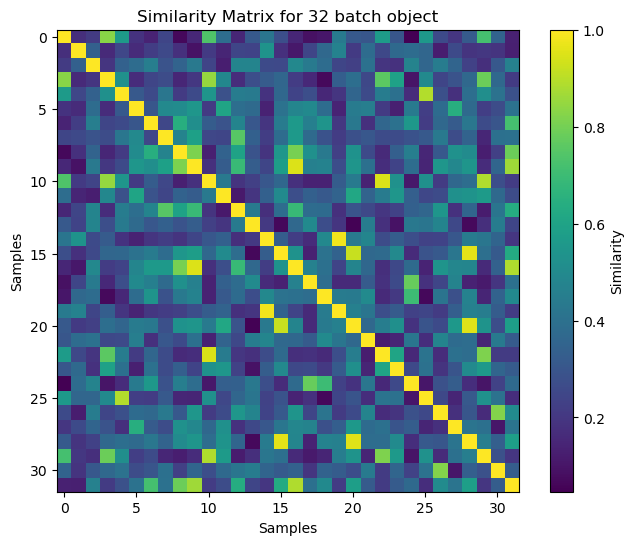

In [20]:
# Plot similarity matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(r_sim.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('Similarity Matrix for 32 batch object')
plt.xlabel('Samples')
plt.ylabel('Samples')
plt.show()

In [21]:
def display_open3d(template):
    
    def close_window_callback(vis):
        vis.close()  # This will close the visualizer window
    
    template_ = o3d.geometry.PointCloud()
    template_.points = o3d.utility.Vector3dVector(template)
    # template_.paint_uniform_color([1, 0, 0])
    
    # Create a Visualizer instance
    vis = vis = o3d.visualization.VisualizerWithKeyCallback()
    vis.create_window()

    # Add point cloud to the visualizer
    vis.add_geometry(template_)

    # Register the key callback for the 'Q' key to close the window
    vis.register_key_callback(ord('Q'), close_window_callback)

    # Run the visualizer
    vis.run()

    # Destroy the window when done
    vis.destroy_window()

In [25]:
display_open3d(batch[0][6])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# ParaHome read meshes

In [22]:
mesh_path = "/Users/photosartd/repositories/ParaHome/data/objects_combined/laptop_combined.obj"

In [23]:
mesh = o3d.io.read_triangle_mesh(mesh_path)

In [24]:
mesh.compute_vertex_normals()

TriangleMesh with 53470 points and 114159 triangles.

In [25]:
def display_mesh(mesh):
    def close_window_callback(vis):
        vis.close()  # This will close the visualizer window
    # Create a Visualizer instance
    vis = vis = o3d.visualization.VisualizerWithKeyCallback()
    vis.create_window()

    # Add point cloud to the visualizer
    vis.add_geometry(mesh)

    # Register the key callback for the 'Q' key to close the window
    vis.register_key_callback(ord('Q'), close_window_callback)

    # Run the visualizer
    vis.run()

    # Destroy the window when done
    vis.destroy_window()

In [24]:
display_mesh(mesh)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Classes

In [26]:
parahome_objects = os.listdir("/Users/photosartd/repositories/ParaHome/data/objects_combined/")

In [27]:
parahome_objects

['kettle_combined.obj',
 'potlid_combined.obj',
 'book_combined.obj',
 'gasstove_combined.obj',
 'microwave_combined.obj',
 'pot_combined.obj',
 'cuttingboard_combined.obj',
 'chair_combined.obj',
 'diningtable_combined.obj',
 'desk_combined.obj',
 'trashbin_combined.obj',
 'sink_combined.obj',
 'bowl_combined.obj',
 'cup_combined.obj',
 'bookshelf_combined.obj',
 'refrigerator_combined.obj',
 'laptop_combined.obj',
 'pan_combined.obj',
 'knife_combined.obj',
 'salt_combined.obj',
 'washingmachine_combined.obj',
 'drawer_combined.obj']

In [28]:
parahome_classes = list(map(lambda x: x.split("_")[0], parahome_objects))

In [29]:
len(parahome_classes)

22

In [30]:
parahome_classes

['kettle',
 'potlid',
 'book',
 'gasstove',
 'microwave',
 'pot',
 'cuttingboard',
 'chair',
 'diningtable',
 'desk',
 'trashbin',
 'sink',
 'bowl',
 'cup',
 'bookshelf',
 'refrigerator',
 'laptop',
 'pan',
 'knife',
 'salt',
 'washingmachine',
 'drawer']

In [31]:
modelnet_labels = [
    'airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car',
    'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot',
    'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor',
    'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
    'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase',
    'wardrobe', 'xbox'
]

In [32]:
model_net_idx_to_label = dict(zip(range(0, 40), modelnet_labels))

In [33]:
model_net_label_to_idx = {label: idx for idx, label in model_net_idx_to_label.items()}

In [34]:
intersection_set = set(parahome_classes).intersection(set(modelnet_labels))

In [35]:
intersection_set

{'bookshelf', 'bowl', 'chair', 'cup', 'desk', 'laptop', 'sink'}

NOTE: only sink and laptop are compound objects

# Plan:
1. For each object in parahome - create embeddings of PCs
2. For each object from dataset that intersects with ParaHome - create embeddings
3. For each embedding from p.2 - find closes object from ParaHome
4. Create confusion matrix

## ParaHome embeddings

In [36]:
def parahome_calculate_embs(path, num_points=1024):
    #Find objects paths
    parahome_objects = os.listdir(path)
    parahome_objects_paths = list(
        map(
            lambda name: os.path.join(path, name),
            parahome_objects
        )
    )
    
    #load
    point_clouds = []
    for mesh_path in parahome_objects_paths:
        mesh = o3d.io.read_triangle_mesh(mesh_path)
        mesh.compute_vertex_normals()
        pcd = mesh.sample_points_uniformly(number_of_points=num_points)
        point_clouds.append(torch.from_numpy(np.asarray(pcd.points, dtype=np.float32)))
    return torch.stack(point_clouds, dim=0)

In [37]:
parahome_pcs = parahome_calculate_embs("/Users/photosartd/repositories/ParaHome/data/objects_combined/", 1024)

In [38]:
parahome_pcs.shape

torch.Size([22, 1024, 3])

In [39]:
batch[0].dtype

torch.float32

In [40]:
parahome_pcs.dtype

torch.float32

In [41]:
with torch.no_grad():
    parahome_embeddings = model(parahome_pcs)

In [42]:
parahome_embeddings.shape

torch.Size([22, 256])

In [43]:
parahome_similarities = torch.nn.functional.cosine_similarity(
    parahome_embeddings.unsqueeze(1),
    parahome_embeddings.unsqueeze(0),
    dim=2
)

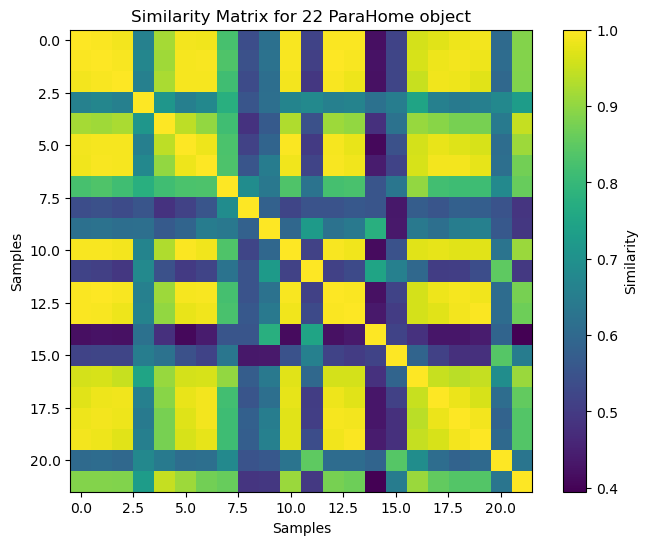

In [44]:
# Plot similarity matrix as heatmap
plt.figure(figsize=(8, 6))
plt.imshow(parahome_similarities, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('Similarity Matrix for 22 ParaHome object')
plt.xlabel('Samples')
plt.ylabel('Samples')
plt.show()

**Q:** does normalization play a role here? No, look at means

In [45]:
batch[0].mean(dim=[1, 2])

tensor([-9.4137e-04,  1.6535e-03,  1.2356e-04, -1.8410e-02, -5.9877e-03,
        -8.5404e-03,  1.1906e-04, -3.6445e-03,  1.8432e-03,  4.4842e-03,
         9.8489e-06,  6.4746e-03, -1.0430e-03,  1.6662e-03, -4.3419e-03,
        -1.2404e-03,  1.1294e-03,  1.5746e-03,  1.2764e-03,  6.4112e-04,
         1.4609e-03, -3.1221e-03, -2.7974e-03, -2.5187e-03,  1.8772e-03,
         1.6095e-04,  2.4331e-03, -3.6502e-03, -3.1797e-04, -1.6217e-03,
        -5.2858e-03, -4.5632e-03])

In [46]:
batch[0].std(dim=[1, 2])

tensor([0.2779, 0.4076, 0.2726, 0.2684, 0.3365, 0.3685, 0.3781, 0.3422, 0.3584,
        0.3542, 0.3403, 0.3762, 0.3292, 0.3287, 0.3725, 0.2784, 0.3590, 0.3870,
        0.3697, 0.3591, 0.2955, 0.3704, 0.3716, 0.4055, 0.3790, 0.2276, 0.2798,
        0.3409, 0.2853, 0.3728, 0.2981, 0.4030])

In [47]:
parahome_pcs.mean(dim=[1, 2])

tensor([ 0.0013, -0.0010, -0.0021,  0.0496, -0.0190, -0.0011, -0.0019, -0.0076,
        -0.0231,  0.0044, -0.0009, -0.0299, -0.0002,  0.0006, -0.0049,  0.0197,
         0.0398,  0.0072, -0.0034,  0.0003, -0.0170, -0.0081])

In [48]:
parahome_pcs.std(dim=[1, 2])

tensor([0.0427, 0.0482, 0.0609, 0.2591, 0.1149, 0.0593, 0.0705, 0.1752, 0.2939,
        0.2819, 0.0525, 0.2601, 0.0443, 0.0308, 0.3050, 0.2674, 0.1044, 0.0708,
        0.0425, 0.0253, 0.2405, 0.1182])

## ModelNet filtered

In [49]:
model_net_idx_to_label_intersection = {idx: label for idx, label in model_net_idx_to_label.items() if 
                                      label in intersection_set}

In [50]:
model_net_idx_to_label_intersection

{4: 'bookshelf',
 6: 'bowl',
 8: 'chair',
 10: 'cup',
 12: 'desk',
 20: 'laptop',
 29: 'sink'}

In [51]:
testset.data_class.data.shape

(9840, 2048, 3)

In [52]:
class FilteredModelNet(torch.utils.data.Dataset):
    def __init__(self, classification_data: ClassificationData, allowed_labels: dict):
        self.cls_data = classification_data
        self.allowed_labels = allowed_labels
        
        self.idx_to_label = {
            idx: label[0] for idx, label in enumerate(self.cls_data.data_class.labels)
            if label[0] in allowed_labels
        }
        self.labels = list(self.idx_to_label.values())
        self.data_label = [self.cls_data.data_class[idx] for idx in self.idx_to_label.keys()]
        
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data_label[idx]

In [53]:
filtered_dataset = FilteredModelNet(testset, model_net_idx_to_label_intersection)

In [54]:
filtered_dataloader = DataLoader(filtered_dataset, batch_size=128, shuffle=False, drop_last=False)

In [55]:
next(iter(filtered_dataloader))[0].shape

torch.Size([128, 1024, 3])

In [56]:
len(filtered_dataset)

2081

## ModelNet embeddings

In [57]:
def inference(model, dataloader):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for pcs, labels in tqdm(dataloader):
            embeddings.append(model(pcs))
    return torch.vstack(embeddings)

In [58]:
modelnet_embeddings = inference(model, filtered_dataloader)

100%|███████████████████████████████████████████| 17/17 [01:02<00:00,  3.65s/it]


In [59]:
modelnet_embeddings.shape

torch.Size([2081, 256])

In [60]:
similarities = torch.nn.functional.cosine_similarity(
    modelnet_embeddings.unsqueeze(1),
    parahome_embeddings.unsqueeze(0),
    dim=2
)

In [61]:
similarities.shape

torch.Size([2081, 22])

In [62]:
most_similar_indices = similarities.max(dim=1)[1]

**Do we need also to look at some top-k metric?**

In [63]:
df_sim = pd.DataFrame(
    {"modelnet_idx": filtered_dataset.labels,
    "parahome_idx": most_similar_indices.numpy()}
)

In [64]:
parahome_idx_to_label = {idx: label for idx, label in enumerate(parahome_classes)}

In [76]:
parahome_label_to_idx = {label: idx for idx, label in parahome_idx_to_label.items()}

In [65]:
df_sim["modelnet_label"] = df_sim["modelnet_idx"].map(model_net_idx_to_label)
df_sim["parahome_label"] = df_sim["parahome_idx"].map(parahome_idx_to_label)

In [66]:
df_sim

,modelnet_idx,parahome_idx,modelnet_label,parahome_label
0,12,15,desk,refrigerator
1,29,8,sink,diningtable
2,4,14,bookshelf,bookshelf
3,8,11,chair,sink
4,4,9,bookshelf,desk
...,...,...,...,...
2076,4,7,bookshelf,chair
2077,8,8,chair,diningtable
2078,8,11,chair,sink
2079,8,11,chair,sink


In [67]:
df_sim["modelnet_label"].unique()

array(['desk', 'sink', 'bookshelf', 'chair', 'cup', 'laptop', 'bowl'],
      dtype=object)

In [68]:
df_sim["parahome_label"].unique()

array(['refrigerator', 'diningtable', 'bookshelf', 'sink', 'desk',
       'chair', 'washingmachine', 'pan', 'pot', 'salt', 'trashbin',
       'drawer', 'knife', 'gasstove'], dtype=object)

In [69]:
confusion_mat = pd.crosstab(df_sim["modelnet_label"], df_sim["parahome_label"])

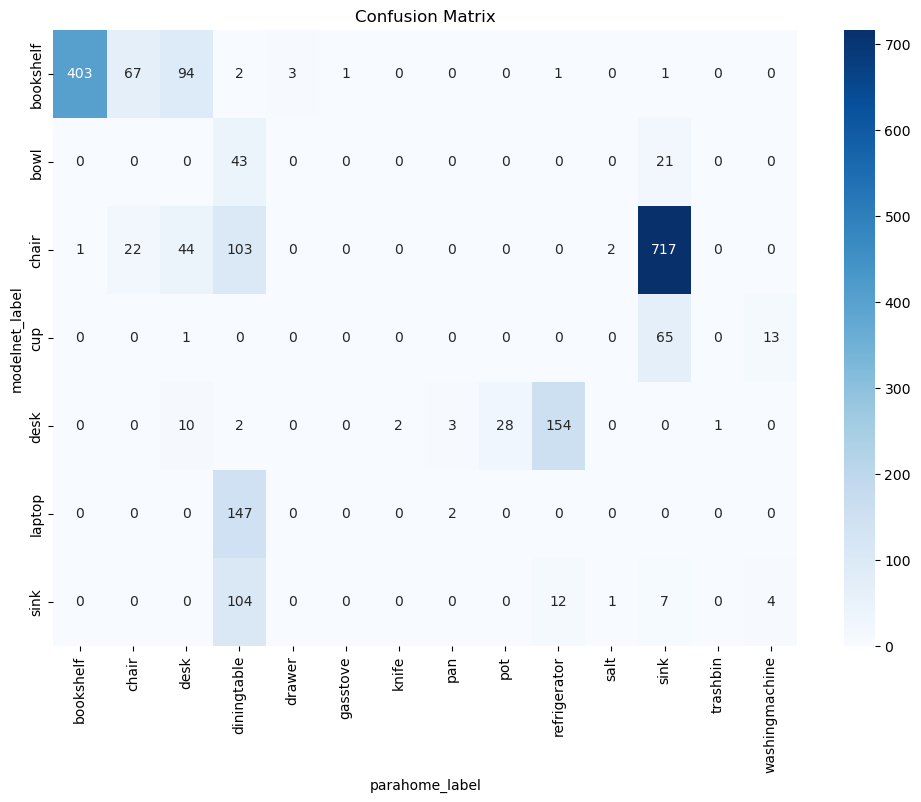

In [70]:
# Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

**Q:** why are the results so bad?

In [71]:
def show_modelnet_obj(dataloader, category: str, num=0):
    if category not in model_net_label_to_idx:
        raise ValueError(f"{category} not in ModelNet categories")
    num_obj = 0
    idx = model_net_label_to_idx[category]
    for batch, labels in dataloader:
        labels = labels.flatten().tolist()
        if idx not in labels:
            continue
        if num_obj >= num:
            curr_idx = labels.index(idx)
            display_open3d(batch[curr_idx])
            break
        else:
            num_obj += 1
            continue

In [81]:
show_modelnet_obj(filtered_dataloader, "laptop", 7)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [77]:
def show_parahome_obj(category: str):
    idx = parahome_label_to_idx[category]
    
    mesh = parahome_pcs[idx]
    display_open3d(mesh)

In [80]:
show_parahome_obj("laptop")

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [60]:
display_open3d(batch[0][26])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
